# Implementing a new helical magnetic field

In this notebook, a new (and more general) helical magnetic field is implemented. This is a *cylindrical force-free field*, constructed using Chandrasekhar-Kendall function. 

It is given by:

$$ B_r(r,\phi, z) = -\frac{B}{\gamma}\left[\frac{m\lambda}{\gamma r} J_m(\gamma r) +kJ_m'(\gamma r)\right] \sin(m\phi+kx) $$

$$ B_\phi(r,\phi, z) = -\frac{B}{\gamma}\left[\frac{mk}{\gamma r} J_m(\gamma r) +\lambda J_m'(\gamma r)\right] \cos(m\phi+kx) $$

$$ B_z(r,\phi, z) = B J_m(\gamma r)\cos(m\phi+kx) $$

Where $J_m$ is the Bessel function of first kind.

## Testing the new field
### Basic imports and grid

In [1]:
import os, sys
sys.path.append('../')

import imagine as img
import numpy as np
import astropy.units as u
import shell
from shell.CK_field import CK_magnetic_field
import shell.visualization as visu

In [2]:

L = 70*u.pc
N = 128

grid = img.fields.UniformGrid(# coordinate values for edges of the grid box
                       box=[[-L,L],[-L,L],[-L,L]], 
                       # Grid resolution
                       resolution=[N, N, N])


In [6]:

1/20, 1/10

(0.05, 0.1)

### Inspecting the CK field 

First let us look at an arbitrarily complicated case: $\,m=1$, $\,k = 0.05\,{\rm pc}^{-1}$ and $\,\gamma = 0.1\,{\rm pc}^{-1}$  (I chose small periods so that the oscilations are evident within the box).

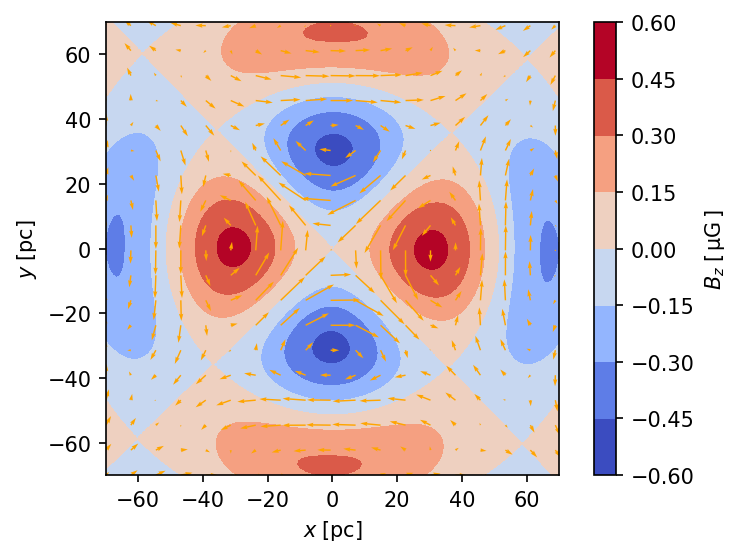

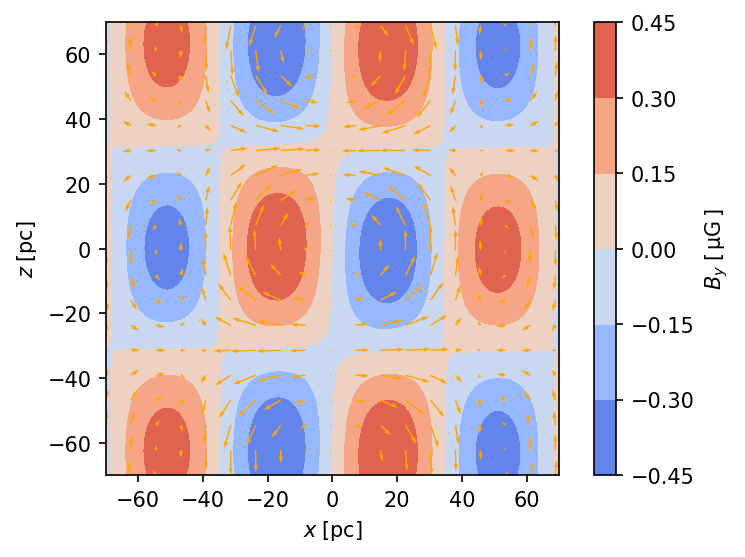

In [7]:
Bx, By, Bz = CK_magnetic_field(grid, period=10*u.pc, period_z=20*u.pc, m=2)

visu.plot_vector_xy(grid, [Bx, By, Bz], skip=7, show_z_component=True, name='B_z');
visu.plot_vector_xz(grid, [Bx, By, Bz], skip=7, show_y_component=True, name='B_y');

Now the simplest case, known as *Bessel Function Model*, where $m=0$, $k=0$ and 
$\gamma=0.1\, {\rm pc}^{-1}$.

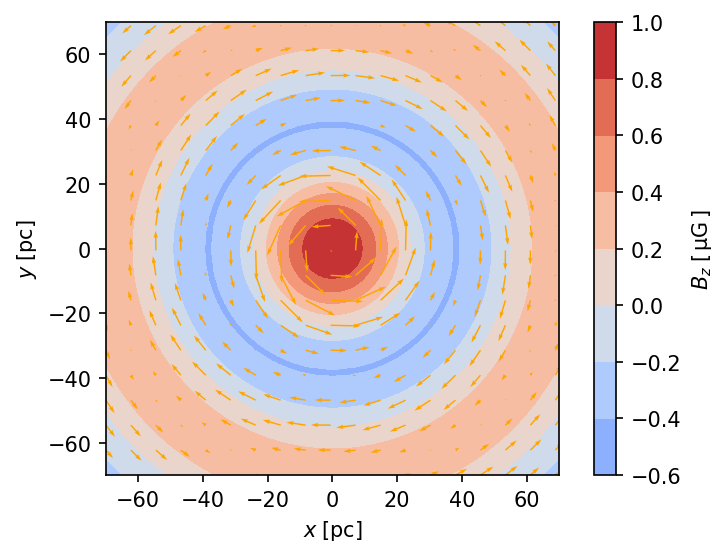

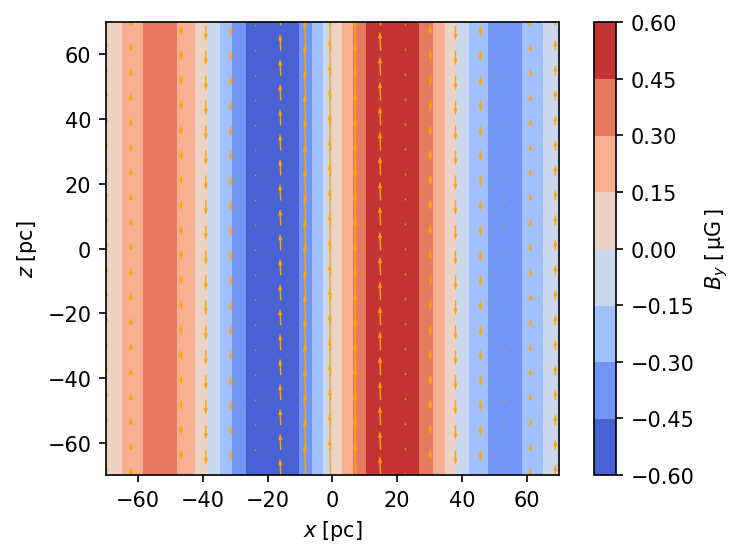

In [12]:
Bx, By, Bz = CK_magnetic_field(grid, period=10*u.pc, period_z=np.inf*u.pc, m=0)

visu.plot_vector_xy(grid, [Bx, By, Bz], skip=7, show_z_component=True, name='B_z');
visu.plot_vector_xz(grid, [Bx, By, Bz], skip=7, show_y_component=True, name='B_y');

## IMAGINE CK fields